# **S&P 500 Market Regime Classification**
## Hybrid Quantum-Classical Neural Networks in Finance

#### **Author / Date**
**[qubit-lab.ch](https://qubit-lab.ch)**  /  November 2025  

#### **Description**
This notebook demonstrates a **hybrid quantum-classical model** for classifying **S&P 500 market regimes** based on volatility, trend, and risk sentiment.  
It combines classical encoding and post-processing layers with an **8-qubit variational quantum circuit**, trained end-to-end for a **multi-class classification** task.  
The setup enables a fair comparison between purely classical and hybrid quantum architectures.

#### **Versions used**
See the first cells below for environment and package versions.

#### **Further resources**
Find the explaining video, related notebooks, and additional finance use cases on  
👉 **[qubit-lab.ch](https://qubit-lab.ch)**  

#### **Overview**
This section prepares the S&P 500 **market regime** dataset used in the hybrid quantum-classical experiment.  
Market data for **SPY, VIX, VVIX,** and the **US 10-Year yield (TNX)** are fetched via `yfinance`, processed into consistent daily time series, and enhanced with derived features and regime targets.

The main **input features** per day include:
- **Price & return dynamics**: log returns (`ret_1`), 5d and 20d cumulative returns (`ret_5`, `ret_20`), absolute returns, intraday range.  
- **Realized volatility structure**: 5d and 20d realized vol (`rv5`, `rv20`), their ratio (`rv_ratio`).  
- **Volatility indices**: VIX, VVIX, VIX slope and relative changes, VVIX changes.  
- **Rates & macro**: US 10Y yield level and 5d changes.  
- **Trend indicators**: fast/slow moving averages of SPY and VIX and their ratios (price- and vol-trend proxies).

#### **Main steps**
1. **Data download** — Retrieve SPY, VIX, VVIX, and TNX in a single API call.  
2. **Pre-processing** — Flatten multi-index columns, rename fields, and remove missing values.  
3. **Feature engineering** — Compute returns, realized volatilities, ranges, ratios, trend indicators, and macro deltas.  
4. **Target creation** — Define next-period realized volatility (regression) and **4-class market regimes** that combine volatility and trend (classification).  
5. **Train/validation/test split** — Chronologically divided to avoid look-ahead bias.  
6. **Sanity plot** — Visual confirmation of realized vs. future volatility trends.

#### **Result**
A ready-to-use dataset:
- `X_train`, `X_val`, `X_test` — model inputs  
- `y_reg` — log-realized volatility target (optional regression head)  
- `y_clf` — 4-class **market regime** labels for the classification task  

> ⚙️ Uses the new `yfinance` default `auto_adjust=True` for stable adjusted prices.

## **Feature Summary — 17 Input Variables**

The hybrid quantum–classical model operates on **17 engineered input features**, grouped into four thematic categories.  
These features capture price action, volatility structure, implied-vol dynamics, and macro signals — ensuring a rich, regime-sensitive representation of market conditions.

---

### **1) Returns & Price Dynamics (5)**
- **`ret_1`** — 1-day log return  
- **`ret_5`** — 5-day cumulative return  
- **`ret_20`** — 20-day cumulative return  
- **`abs_ret`** — absolute daily return  
- **`range`** — intraday range `(High − Low) / Open`

---

### **2) Volatility Structure (3)**
- **`rv5`** — realized volatility over 5 days  
- **`rv20`** — realized volatility over 20 days  
- **`rv_ratio`** — short/long volatility ratio `rv5 / rv20`

---

### **3) VIX / VVIX Dynamics (5)**
- **`VIX`**, **`VVIX`** — levels of implied volatility and vol-of-vol  
- **`vix_slope`** — 5-day minus 20-day VIX moving average  
- **`vix_change`** — 5-day percentage change in VIX  
- **`vvix_change`** — 5-day percentage change in VVIX

---

### **4) Macro & Trend Indicators (4)**
- **`US10Y`** — level of the 10-year Treasury yield  
- **`yield_change`** — 5-day change in yields  
- **`ma_ratio`** — SPY trend indicator `(MA20 / MA60 − 1)`  
- **`vix_ma_ratio`** — VIX trend indicator `(MA5 / MA20 − 1)`

---

### **➡️ Total Number of Inputs: 17**

These features are used **identically** for both the Classical MLP baseline and the Hybrid 8-Qubit model, ensuring a fully fair and controlled comparison.

/tmp/ipython-input-3388347171.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start="2010-01-01", progress=False)


Columns: ['Close', 'US10Y', 'VIX', 'VVIX', 'High', 'High_TNX', 'High_VIX', 'High_VVIX', 'Low', 'Low_TNX', 'Low_VIX', 'Low_VVIX', 'Open', 'Open_TNX', 'Open_VIX', 'Open_VVIX', 'Volume', 'Volume_TNX', 'Volume_VIX', 'Volume_VVIX']
                Close  US10Y        VIX       VVIX       High  High_TNX  \
Date                                                                      
2010-01-04  85.279205  3.841  20.040001  73.300003  85.324353     3.859   
2010-01-05  85.504951  3.755  19.350000  70.360001  85.542578     3.800   
2010-01-06  85.565155  3.808  19.160000  67.650002  85.775850     3.837   
2010-01-07  85.926369  3.822  19.059999  67.150002  86.031716     3.859   
2010-01-08  86.212296  3.808  18.129999  65.709999  86.249922     3.851   

             High_VIX  High_VVIX        Low  Low_TNX    Low_VIX   Low_VVIX  \
Date                                                                         
2010-01-04  21.680000  73.300003  83.909682    3.808  20.030001  73.300003   
2010-01-05  2

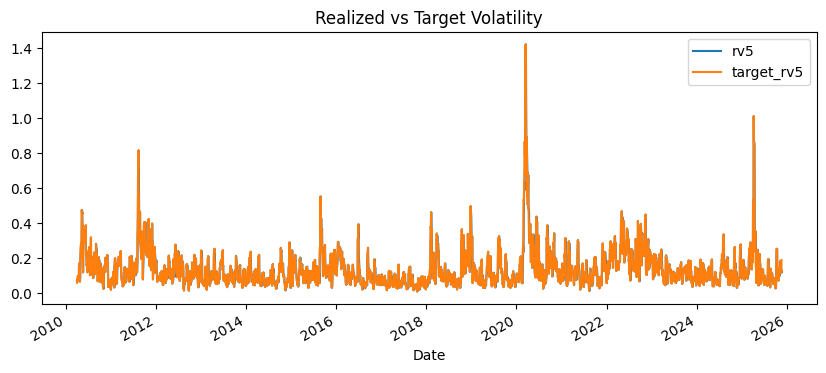

In [ ]:
# ===============================================================
# 📈 FINAL STABLE VERSION — S&P500 MARKET REGIME DATA PREPARATION
# Compatible with new yfinance (auto_adjust=True default)
# ===============================================================
!pip -q install yfinance pandas numpy scikit-learn matplotlib

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# -----------------------------
# 1. Download all data in one call
# -----------------------------
tickers = ["SPY", "^VIX", "^VVIX", "^TNX"]
raw = yf.download(tickers, start="2010-01-01", progress=False)

# yfinance now gives a MultiIndex (Level 0 = field, Level 1 = ticker)
# e.g. ('Close', 'SPY'), ('Close', '^VIX'), etc.
if isinstance(raw.columns, pd.MultiIndex):
    # flatten
    raw.columns = [f"{col[0]}_{col[1].replace('^','')}" for col in raw.columns]
else:
    raw.columns = [col for col in raw.columns]

# Rename to simpler names
df = raw.rename(columns={
    "Close_SPY": "Close",
    "Open_SPY": "Open",
    "High_SPY": "High",
    "Low_SPY": "Low",
    "Volume_SPY": "Volume",
    "Close_VIX": "VIX",
    "Close_VVIX": "VVIX",
    "Close_TNX": "US10Y"
}).dropna()

print("Columns:", df.columns.tolist())
print(df.head())

# -----------------------------
# 2. Compute returns & realized volatility
# -----------------------------
# Adjusted Close no longer exists (auto-adjust done), so use Close directly
df["ret"] = np.log(df["Close"]).diff()

# Rolling realized vols (annualized)
df["rv5"]  = df["ret"].rolling(5).std()  * np.sqrt(252)
df["rv20"] = df["ret"].rolling(20).std() * np.sqrt(252)

# Future target vol (next 5 days)
df["target_rv5"]    = df["ret"].shift(-1).rolling(5).std() * np.sqrt(252)
df["log_rv_target"] = np.log(df["target_rv5"])

# -----------------------------
# 3. Feature engineering
# -----------------------------
# Returns & price-based features
df["ret_1"]   = df["ret"]
df["ret_5"]   = df["ret"].rolling(5).sum()
df["ret_20"]  = df["ret"].rolling(20).sum()
df["abs_ret"] = df["ret"].abs()
df["range"]   = (df["High"] - df["Low"]) / df["Open"]

# Vol structure
df["rv_ratio"] = df["rv5"] / df["rv20"]

# VIX / VVIX dynamics
df["vix_slope"]   = df["VIX"].rolling(5).mean() - df["VIX"].rolling(20).mean()
df["vix_change"]  = df["VIX"].pct_change(5)
df["vvix_change"] = df["VVIX"].pct_change(5)

# Rates / macro
df["yield_change"] = df["US10Y"].diff(5)

# Trend indicators (price & vol)
df["ma_fast"]     = df["Close"].rolling(20).mean()
df["ma_slow"]     = df["Close"].rolling(60).mean()
df["ma_ratio"]    = df["ma_fast"] / df["ma_slow"] - 1

df["vix_ma_fast"]  = df["VIX"].rolling(5).mean()
df["vix_ma_slow"]  = df["VIX"].rolling(20).mean()
df["vix_ma_ratio"] = df["vix_ma_fast"] / df["vix_ma_slow"] - 1

# Drop initial NaNs from rolling windows
df = df.dropna()

# -----------------------------
# 4. Market regimes (4 classes)
# -----------------------------
# Use both trend (20d return) and future vol level (log_rv_target) to define regimes:
# 0 = Calm bull       (low vol, positive trend)
# 1 = Sideways/normal (low–mid vol, flat trend)
# 2 = Correction/bear (elevated vol, negative trend)
# 3 = Crisis/stress   (very high vol, any trend)

ret_q_low, ret_q_high = df["ret_20"].quantile([0.33, 0.67])
vol_q_high  = df["log_rv_target"].quantile(0.67)
vol_q_very  = df["log_rv_target"].quantile(0.90)

conditions = [
    # Calm bull
    (df["log_rv_target"] < vol_q_high) & (df["ret_20"] > ret_q_high),
    # Sideways / normal
    (df["log_rv_target"] < vol_q_high) & (df["ret_20"].between(ret_q_low, ret_q_high)),
    # Correction / bear
    (df["log_rv_target"] < vol_q_very) & (df["ret_20"] < ret_q_low),
    # Crisis / stress
    (df["log_rv_target"] >= vol_q_very)
]

choices = [0, 1, 2, 3]
df["regime"] = np.select(conditions, choices, default=1).astype(int)

# -----------------------------
# 5. Feature selection & splits
# -----------------------------
features = [
    "ret_1", "ret_5", "ret_20", "abs_ret", "range",
    "rv5", "rv20", "rv_ratio",
    "VIX", "VVIX", "vix_slope", "vix_change", "vvix_change",
    "US10Y", "yield_change",
    "ma_ratio", "vix_ma_ratio"
]
input_dim = len(features)  # number of input features used for training

X     = df[features]
y_reg = df["log_rv_target"]       # optional regression target
y_clf = df["regime"].astype(int)  # 4-class regime labels

split1, split2 = int(len(df)*0.7), int(len(df)*0.85)
X_train, X_val, X_test = X.iloc[:split1], X.iloc[split1:split2], X.iloc[split2:]
y_reg_train, y_reg_val, y_reg_test = y_reg.iloc[:split1], y_reg.iloc[split1:split2], y_reg.iloc[split2:]
y_clf_train, y_clf_val, y_clf_test = y_clf.iloc[:split1], y_clf.iloc[split1:split2], y_clf.iloc[split2:]

print(f"\nTrain/Val/Test sizes: {len(X_train)}, {len(X_val)}, {len(X_test)}")
print("Regime distribution (train):", y_clf_train.value_counts(normalize=True).round(3).to_dict())

# -----------------------------
# 6. Sanity plot
# -----------------------------
df[["rv5", "target_rv5"]].plot(title="Realized vs Target Volatility", figsize=(10, 4))
plt.show()

#### **Overview**
After preparing and splitting the dataset, this step standardizes the input features and converts all data into PyTorch tensors for efficient training of the **4-class market regime classifier**.

#### **Main steps**
1. **Feature scaling** — Apply `StandardScaler` (fit on the training set only) so all input features have zero mean and unit variance.  
2. **Tensor conversion** — Transform the scaled NumPy arrays into `torch.FloatTensor` for inputs and `torch.LongTensor` for the regime labels.  
3. **DataLoader setup** — Wrap tensors into `TensorDataset` and `DataLoader` objects to enable mini-batch training, validation, and testing.

#### **Result**
- Scaled input tensors (`X_train_t`, `X_val_t`, `X_test_t`)  
- Corresponding **4-class market regime labels** (`y_train_t`, `y_val_t`, `y_test_t`)  
- Ready-to-use `DataLoader` objects for each split

> 🧩 Ensures consistent preprocessing and batching for both classical and hybrid quantum models.

In [ ]:
# ===============================================================
# 🔧 FEATURE SCALING + TORCH DATASETS (MARKET REGIMES, CLASSIFICATION ONLY)
# ===============================================================
!pip -q install torch scikit-learn

import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# --- 1) Standardize features (fit only on training set) ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)

# --- 2) Convert to PyTorch tensors (classification only) ---
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_clf_train.values, dtype=torch.long)  # 4-class regimes

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_clf_val.values, dtype=torch.long)

X_test_t = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_t = torch.tensor(y_clf_test.values, dtype=torch.long)

# --- 3) Create TensorDatasets & DataLoaders ---
BATCH_SIZE = 64

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE)

print("Tensors ready:")
print(f"Train loader batches: {len(train_loader)}")
print("Input dimension:", X_train_t.shape[1])
print("Example X batch:", next(iter(train_loader))[0].shape)
print("Example y batch:", next(iter(train_loader))[1].shape)

Tensors ready:
Train loader batches: 43
Input dimension: 17
Example X batch: torch.Size([64, 17])
Example y batch: torch.Size([64])


#### **Overview**
This section defines the reusable training and evaluation routines used for both classical and hybrid quantum models on the **4-class market regime** task.  
It introduces early stopping, automatic loss logging, and consistent metric collection for a fair comparison between architectures.

#### **Main steps**
1. **Training loop (`train_with_earlystop`)** —  
   Implements epoch-based training with **cross-entropy loss**, gradient clipping, and early stopping based on validation loss.  
   Records both training and validation loss histories for later visualization.

2. **Evaluation function (`evaluate_model`)** —  
   Runs inference on the test set, builds a **4×4 confusion matrix**, and computes classification metrics:  
   overall accuracy, F1-macro, and recall for each of the four market regimes.

3. **Metric helper (`cm_to_metrics`)** —  
   Converts the confusion matrix into aggregate metrics (accuracy, F1-macro) and a vector of per-regime recalls,  
   used to summarize and compare the **Classical MLP** and **Hybrid 8Q** results.

#### **Result**
- Early-stopped, fully trained models  
- Logged training/validation histories (`train_hist`, `val_hist`)  
- Structured evaluation outputs: accuracy, F1-macro, per-regime recall, and confusion matrix  

> 📊 Enables reproducible, quantitative comparison between the **Classical MLP** and **Hybrid 8Q** architectures on the market regime classification task.

In [ ]:
# ===============================================================
# ⚙️ Install PennyLane (for Quantum Hybrid Models)
# ===============================================================
!pip -q install "pennylane-lightning>=0.38"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 6.0 MB/s eta 0:00:00


In [ ]:
# ===============================================================
# 🚀 IMPROVED HYBRID QUANTUM-CLASSICAL MODEL (MARKET REGIMES, CLASSIFICATION ONLY)
# ===============================================================
import io
import random
import contextlib
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pennylane as qml

PREPROCESSING_NEURONS = 24
N_CLASSES = 4  # 4 market regimes


# =========================================================
# 🔧 DEVICE
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================================================
# 🔁 UTILS
# =========================================================
def set_seed_all(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


def fmt_delta_pct(d: float) -> str:
    sign = "+" if d >= 0 else ""
    return f"{sign}{d * 100:.1f}%"


def fmt_delta(d: float) -> str:
    sign = "+" if d >= 0 else ""
    return f"{sign}{d:.3f}"


def cm_to_metrics(cm):
    """
    Confusion matrix (rows = true class, cols = predicted class).
    Returns: acc, f1_macro, recalls_per_class (list of length N_CLASSES).
    """
    if cm is None:
        return 0.0, 0.0, [None] * N_CLASSES
    cm = np.array(cm, dtype=float)
    if cm.shape != (N_CLASSES, N_CLASSES):
        return 0.0, 0.0, [None] * N_CLASSES

    total = cm.sum()
    if total <= 0:
        return 0.0, 0.0, [None] * N_CLASSES

    acc = float(np.trace(cm) / total)

    # recall (row-wise)
    recalls = []
    for i in range(N_CLASSES):
        row_sum = cm[i, :].sum()
        r = (cm[i, i] / row_sum) if row_sum > 0 else 0.0
        recalls.append(float(r))

    # precision (col-wise)
    precisions = []
    for i in range(N_CLASSES):
        col_sum = cm[:, i].sum()
        p = (cm[i, i] / col_sum) if col_sum > 0 else 0.0
        precisions.append(float(p))

    f1s = []
    for p, r in zip(precisions, recalls):
        if p + r > 0:
            f1s.append(2 * p * r / (p + r))
        else:
            f1s.append(0.0)
    f1_macro = float(np.mean(f1s))

    return acc, f1_macro, recalls


# =========================================================
# 🧪 EARLY-STOP TRAINING (CLASSIFICATION ONLY)
# =========================================================
def train_with_earlystop(
    model,
    name,
    lr=3e-4,
    patience=15,
    max_epochs=50,
    max_grad_norm=1.0,
    verbose=False,
    log_every=10,
):
    """
    Training loop for pure classification:
    - Uses CrossEntropyLoss only
    - Early stopping on validation loss
    """
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    best_val = float("inf")
    best_state = None
    no_improve = 0
    train_hist, val_hist = [], []

    for epoch in range(1, max_epochs + 1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = F.cross_entropy(logits, yb)
            loss.backward()
            if max_grad_norm is not None:
                nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            opt.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)
        train_hist.append(train_loss)

        # validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                logits = model(xb)
                loss = F.cross_entropy(logits, yb)
                val_loss += loss.item() * xb.size(0)
        val_loss /= len(val_loader.dataset)
        val_hist.append(val_loss)

        if verbose and (epoch == 1 or epoch % log_every == 0):
            print(f"{name} Ep{epoch:03d} | Train {train_loss:.3f} | Val {val_loss:.3f}")

        # early stopping
        if val_loss < best_val - 1e-6:
            best_val = val_loss
            best_state = copy.deepcopy(model.state_dict())
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                if verbose:
                    print(f"{name}: early stop at {epoch} (best Val {best_val:.4f})")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model, (train_hist, val_hist)


# =========================================================
# 📊 EVAL — CONFUSION MATRIX
# =========================================================
def evaluate_model(model):
    """
    Evaluate on global test_loader.
    Returns: {"cm": N_CLASSES x N_CLASSES confusion matrix (counts)}
    """
    model = model.to(device)
    model.eval()
    cm = np.zeros((N_CLASSES, N_CLASSES), dtype=int)
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            logits = model(xb)
            preds = logits.argmax(dim=1)
            for t, p in zip(yb.view(-1), preds.view(-1)):
                cm[int(t.item()), int(p.item())] += 1
    return {"cm": cm.tolist()}


# =========================================================
# 🏗️ CLASSICAL BASELINE WITH EXPOSED ENCODER
# =========================================================
class ClassicalMLP_EncHead(nn.Module):
    def __init__(self, input_dim, n_qubits=8):
        super().__init__()
        self.n_qubits = n_qubits
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, PREPROCESSING_NEURONS),
            nn.ReLU(),
            nn.Linear(PREPROCESSING_NEURONS, n_qubits),
        )
        self.head = nn.Sequential(
            nn.Linear(n_qubits, n_qubits),
            nn.ReLU(),
            nn.Linear(n_qubits, N_CLASSES),
        )

    def forward(self, x):
        z = self.encoder(x)
        logits = self.head(z)
        return logits


# =========================================================
# 🔗 IMPROVED HYBRID MODEL (FROZEN PRETRAINED ENCODER)
# =========================================================
class ImprovedHybrid8Q(nn.Module):
    def __init__(
        self,
        input_dim,
        n_qubits=8,
        q_layers=3,
        input_scale=1.0,
        noise_factor=0.0,
        pretrained_encoder: nn.Sequential = None,
        freeze_encoder: bool = True,
        partial_unfreeze: bool = False,  # option to unfreeze last encoder layer
    ):
        super().__init__()
        self.n_qubits = n_qubits
        self.q_layers = q_layers
        self.input_scale = input_scale
        self.noise_factor = noise_factor

        # Encoder (frozen or partial)
        if pretrained_encoder is not None:
            self.encoder = copy.deepcopy(pretrained_encoder)
        else:
            self.encoder = nn.Sequential(
                nn.Linear(input_dim, PREPROCESSING_NEURONS),
                nn.ReLU(),
                nn.Linear(PREPROCESSING_NEURONS, n_qubits),
            )

        if freeze_encoder:
            for p in self.encoder.parameters():
                p.requires_grad = False
            if partial_unfreeze:
                # Unfreeze last layer (Linear(PREPROCESSING_NEURONS, n_qubits))
                for p in self.encoder[2].parameters():
                    p.requires_grad = True

        # Trainable output scaling factor
        self.output_scale = nn.Parameter(torch.full((self.n_qubits,), 3.0))

        # Quantum device
        try:
            dev = qml.device("lightning.qubit", wires=n_qubits)
            diff_method = "adjoint"
        except Exception:
            dev = qml.device("default.qubit", wires=n_qubits)
            diff_method = "best"

        @qml.qnode(dev, interface="torch", diff_method=diff_method)
        def qnode(inputs, weights):
            qml.AngleEmbedding(inputs * self.input_scale, wires=range(n_qubits), rotation="Y")

            for layer in range(q_layers):
                for i in range(n_qubits):
                    qml.Rot(*weights[layer, i, :3], wires=i)
                for i in range(n_qubits - 1):
                    qml.CZ(wires=[i, i + 1])
                if n_qubits > 2:
                    qml.CZ(wires=[n_qubits - 1, 0])

            return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

        weight_shapes = {"weights": (q_layers, n_qubits, 3)}
        self.qlayer = qml.qnn.TorchLayer(qnode, weight_shapes)

        # Post-processing head (now to N_CLASSES)
        self.post = nn.Sequential(
            nn.Linear(n_qubits, n_qubits),
            nn.BatchNorm1d(n_qubits),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(n_qubits, N_CLASSES),
        )

    def forward(self, x):
        z = self.encoder(x)
        if self.noise_factor != 0.0:
            z = z + self.noise_factor * torch.randn_like(z)

        q_out = self.qlayer(z)
        q_out = q_out * self.output_scale
        logits = self.post(q_out)
        return logits


# =========================================================
# DIAGNOSTIC FUNCTION TO CHECK QUANTUM CIRCUIT
# =========================================================
def check_quantum_circuit(model, test_input):
    """Check if quantum circuit is working properly."""
    model.eval()
    with torch.no_grad():
        z = model.encoder(test_input)
        print(f"Encoder output range: [{z.min():.3f}, {z.max():.3f}]")
        print(f"Encoder output mean: {z.mean():.3f} ± {z.std():.3f}")

        q_out_raw = model.qlayer(z)
        print(f"Raw quantum output range: [{q_out_raw.min():.3f}, {q_out_raw.max():.3f}]")
        print(f"Raw quantum output mean: {q_out_raw.mean():.3f} ± {q_out_raw.std():.3f}")

        q_out_scaled = q_out_raw * model.output_scale
        print(f"Scaled quantum output range: [{q_out_scaled.min():.3f}, {q_out_scaled.max():.3f}]")
        print(f"Scaled quantum output mean: {q_out_scaled.mean():.3f} ± {q_out_scaled.std():.3f}")

        final_output = model.post(q_out_scaled)
        print(f"Final logits shape: {final_output.shape}")
        print(f"Final logits sample: {final_output[0]}")

        return final_output


# =========================================================
# 1) PRETRAIN CLASSICAL BASELINES (ONCE PER SEED)
# =========================================================
def pretrain_baselines(
    input_dim,
    lr_cls=3e-4,
    patience_cls=15,
    max_epochs_cls=40,
    seeds=(42, 111, 234),
    silent=False,
):
    encoders = {}
    baselines = {}
    for seed in seeds:
        set_seed_all(seed)
        model = ClassicalMLP_EncHead(input_dim, n_qubits=8).to(device)
        ctx = contextlib.redirect_stdout(io.StringIO()) if silent else contextlib.nullcontext()
        with ctx:
            trained, _ = train_with_earlystop(
                model,
                name=f"Classical MLP (seed={seed})",
                lr=lr_cls,
                patience=patience_cls,
                max_epochs=max_epochs_cls,
                verbose=not silent,
                log_every=10,
            )
            res = evaluate_model(trained)

        acc, f1, recalls = cm_to_metrics(res.get("cm"))
        # store recalls per regime (0..3)
        baselines[seed] = {
            "acc": acc,
            "f1_macro": f1,
            "recalls": recalls,
        }
        encoders[seed] = copy.deepcopy(trained.encoder)

        r_str = " | ".join([f"R{i} {recalls[i]:.3f}" for i in range(N_CLASSES)])
        print(
            f"🔹 Baseline MLP | seed={seed} | "
            f"Acc {acc*100:.1f}% | F1 {f1:.3f} | {r_str}"
        )
    return encoders, baselines


# =========================================================
# 2) IMPROVED HYBRID SWEEP USING CACHED ENCODERS
# =========================================================
def run_improved_hybrid_sweep(
    input_dim,
    encoders,
    baselines,
    input_scales=[0.5, 1.0, 1.5],
    q_layers_list=[4, 5, 6],
    lr_hyb=5e-4,
    noise_factor=0.01,
    patience_q=15,
    max_epochs_q=60,
    seeds=(42, 111, 234),
    silent=False,
    partial_unfreeze=False,
):
    """
    Improved hybrid sweep with better quantum architecture
    on 4-class market regime classification.
    """
    all_results = []

    # First, test quantum circuit with one sample
    print("🧪 Testing quantum circuit with sample input...")
    sample_seed = seeds[0]
    set_seed_all(sample_seed)
    test_model = ImprovedHybrid8Q(
        input_dim=input_dim,
        n_qubits=8,
        q_layers=3,
        input_scale=1.0,
        pretrained_encoder=encoders[sample_seed],
        freeze_encoder=True,
        partial_unfreeze=partial_unfreeze,
    ).to(device)
    sample_input = X_train_t[:1].to(device)
    check_quantum_circuit(test_model, sample_input)
    print("✅ Quantum circuit test completed\n")

    for scale in input_scales:
        for ql in q_layers_list:
            for seed in seeds:
                set_seed_all(seed)
                base = baselines[seed]
                pretrained_encoder = encoders[seed]

                model = ImprovedHybrid8Q(
                    input_dim=input_dim,
                    n_qubits=8,
                    q_layers=ql,
                    input_scale=scale,
                    noise_factor=noise_factor,
                    pretrained_encoder=pretrained_encoder,
                    freeze_encoder=True,
                    partial_unfreeze=partial_unfreeze,
                ).to(device)

                ctx = contextlib.redirect_stdout(io.StringIO()) if silent else contextlib.nullcontext()
                with ctx:
                    trained, _ = train_with_earlystop(
                        model,
                        name=f"Improved Hybrid 8Q (seed={seed}, s={scale}, L={ql})",
                        lr=lr_hyb,
                        patience=patience_q,
                        max_epochs=max_epochs_q,
                        verbose=not silent,
                        log_every=10,
                    )
                    res = evaluate_model(trained)

                acc_h, f1_h, recalls_h = cm_to_metrics(res.get("cm"))
                recalls_base = base["recalls"]

                delta_acc = acc_h - base["acc"]
                delta_f1 = f1_h - base["f1_macro"]
                delta_recalls = [
                    (recalls_h[i] - recalls_base[i]) if recalls_base[i] is not None else None
                    for i in range(N_CLASSES)
                ]

                # Get learned output scale (mean for summary)
                learned_out_scale = trained.output_scale.mean().item()

                parts = [
                    f"seed={seed}",
                    f"scale={scale}",
                    f"q_layers={ql}",
                    f"lr_hyb={lr_hyb:.0e}",
                    f"noise={noise_factor}",
                    f"out_scale_mean={learned_out_scale:.2f}",
                    f"Delta Acc {fmt_delta_pct(delta_acc)}",
                    f"Delta F1-macro {fmt_delta(delta_f1)}",
                ]
                for i, drec in enumerate(delta_recalls):
                    if drec is not None:
                        parts.append(f"Delta R{i} recall {fmt_delta(drec)}")

                print("🔁 IMPROVED Delta Result | " + " | ".join(parts))

                all_results.append(
                    {
                        "config": {
                            "seed": seed,
                            "input_scale": scale,
                            "q_layers": ql,
                            "lr_hyb": lr_hyb,
                            "noise_factor": noise_factor,
                        },
                        "baseline": base,
                        "hybrid": {
                            "acc": acc_h,
                            "f1_macro": f1_h,
                            "recalls": recalls_h,
                        },
                        "delta": {
                            "acc": delta_acc,
                            "f1_macro": delta_f1,
                            "recalls": delta_recalls,
                        },
                    }
                )
    return all_results

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
# =========================================================
# 3) RUN THE IMPROVED MARKET REGIME EXPERIMENT
# =========================================================
print("🚀 STARTING IMPROVED HYBRID QUANTUM-CLASSICAL EXPERIMENT (MARKET REGIMES)")
print("=" * 60)

# First, pretrain classical baselines
seeds = (342, 3111, 3234, 3345, 3456, 3567, 3678, 3789, 3890, 3901)
encoders, baselines = pretrain_baselines(
    input_dim=input_dim,
    lr_cls=5e-4,
    patience_cls=20,
    max_epochs_cls=200,
    seeds=seeds,
    silent=True,
)

# Run improved hybrid sweep (try with partial_unfreeze=True for better adaptation)
improved_results = run_improved_hybrid_sweep(
    input_dim=input_dim,
    encoders=encoders,
    baselines=baselines,
    input_scales=[0.7],
    q_layers_list=[3],
    lr_hyb=5e-4,
    noise_factor=0.01,
    patience_q=40,
    max_epochs_q=200,
    seeds=seeds,
    silent=True,
    partial_unfreeze=True,  # Enable this for joint fine-tuning
)

print("\n" + "=" * 60)
print("🎯 IMPROVED EXPERIMENT COMPLETED")

# Summary of results
positive_deltas = [r for r in improved_results if r["delta"]["acc"] > 0]
if positive_deltas:
    best_result = max(positive_deltas, key=lambda x: x["delta"]["acc"])
    d = best_result["delta"]
    cfg = best_result["config"]

    print(f"🏆 BEST IMPROVEMENT: Delta Acc {fmt_delta_pct(d['acc'])}")
    print(f"   Delta F1-macro: {fmt_delta(d['f1_macro'])}")
    print(f"   Config: seed={cfg['seed']}, "
          f"scale={cfg['input_scale']}, "
          f"layers={cfg['q_layers']}")

    # Per-regime recall deltas (R0..R3)
    if d["recalls"] is not None:
        for i, dr in enumerate(d["recalls"]):
            if dr is not None:
                print(f"   Delta R{i} recall: {fmt_delta(dr)}")
else:
    print("⚠️  No positive improvements found - quantum circuit may need further tuning")

🚀 STARTING IMPROVED HYBRID QUANTUM-CLASSICAL EXPERIMENT (MARKET REGIMES)
🔹 Baseline MLP | seed=342 | Acc 85.4% | F1 0.801 | R0 0.798 | R1 0.921 | R2 0.907 | R3 0.516
🔹 Baseline MLP | seed=3111 | Acc 82.2% | F1 0.783 | R0 0.700 | R1 0.949 | R2 0.864 | R3 0.548
🔹 Baseline MLP | seed=3234 | Acc 82.7% | F1 0.785 | R0 0.719 | R1 0.986 | R2 0.793 | R3 0.581
🔹 Baseline MLP | seed=3345 | Acc 83.7% | F1 0.791 | R0 0.695 | R1 0.977 | R2 0.900 | R3 0.516
🔹 Baseline MLP | seed=3456 | Acc 87.1% | F1 0.808 | R0 0.872 | R1 0.963 | R2 0.807 | R3 0.516
🔹 Baseline MLP | seed=3567 | Acc 79.8% | F1 0.764 | R0 0.645 | R1 0.949 | R2 0.843 | R3 0.548
🔹 Baseline MLP | seed=3678 | Acc 79.6% | F1 0.763 | R0 0.709 | R1 0.921 | R2 0.786 | R3 0.548
🔹 Baseline MLP | seed=3789 | Acc 84.6% | F1 0.805 | R0 0.803 | R1 0.921 | R2 0.857 | R3 0.548
🔹 Baseline MLP | seed=3890 | Acc 85.6% | F1 0.810 | R0 0.764 | R1 0.967 | R2 0.893 | R3 0.516
🔹 Baseline MLP | seed=3901 | Acc 87.6% | F1 0.830 | R0 0.833 | R1 0.958 | R2 0.871

,seed,DeltaAcc_pp,DeltaF1,DeltaF1_pp,DeltaR0_pp,DeltaR1_pp,DeltaR2_pp,DeltaR3_pp
0,0,0.2,0.005,0.5,3.0,-3.7,1.4,3.2
1,42,-0.3,-0.000,-0.0,-3.9,-0.5,5.1,0.0
2,111,1.0,0.009,0.9,5.4,-2.8,0.0,3.2
3,142,0.8,0.009,0.9,1.5,0.9,-1.4,6.5
4,234,-1.0,0.005,0.5,-2.0,0.9,-7.2,19.4
...,...,...,...,...,...,...,...,...
56,5567,0.5,-0.006,-0.6,-0.5,1.9,-0.7,3.2
57,5678,0.3,-0.024,-2.4,3.5,-3.7,5.0,-12.9
58,5789,-1.0,-0.015,-1.5,-0.5,-0.5,-2.8,0.0
59,5890,2.0,0.020,2.0,3.0,1.4,2.1,0.0


DeltaAcc_pp: mean = 0.32 pp, 95% CI = [-0.02, 0.66] pp
DeltaF1_pp: mean = 0.37 pp, 95% CI = [-0.11, 0.85] pp
DeltaR0_pp: mean = -0.22 pp, 95% CI = [-1.23, 0.78] pp
DeltaR1_pp: mean = 0.02 pp, 95% CI = [-0.55, 0.60] pp
DeltaR2_pp: mean = 0.77 pp, 95% CI = [0.15, 1.40] pp
DeltaR3_pp: mean = 3.97 pp, 95% CI = [1.76, 6.18] pp

ΔAcc mean = 0.32 pp, 95% CI = [-0.02, 0.66] pp
ΔF1 mean  = 0.37 pp, 95% CI = [-0.11, 0.85] pp


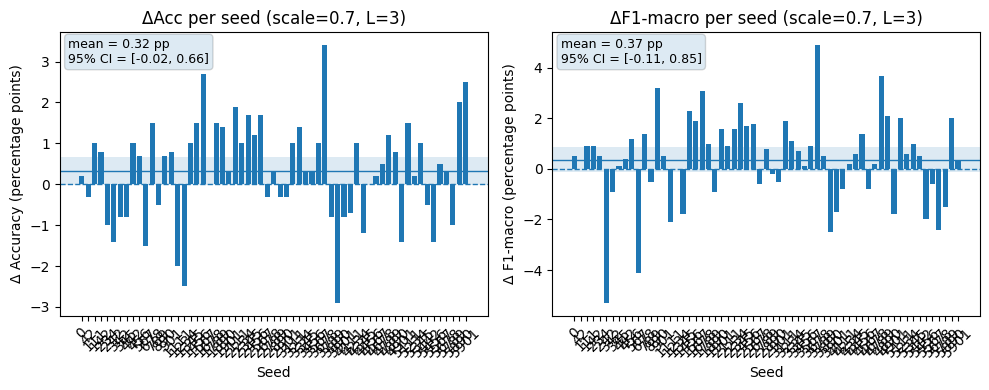

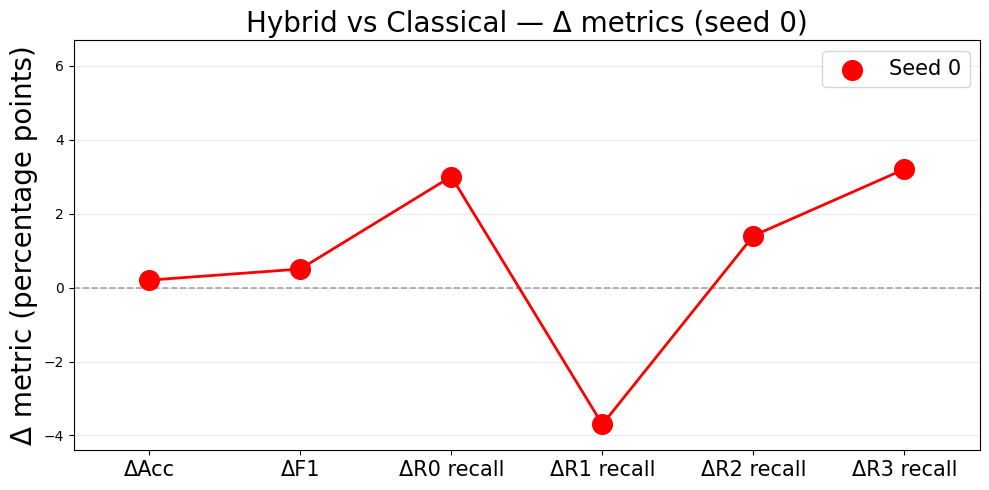

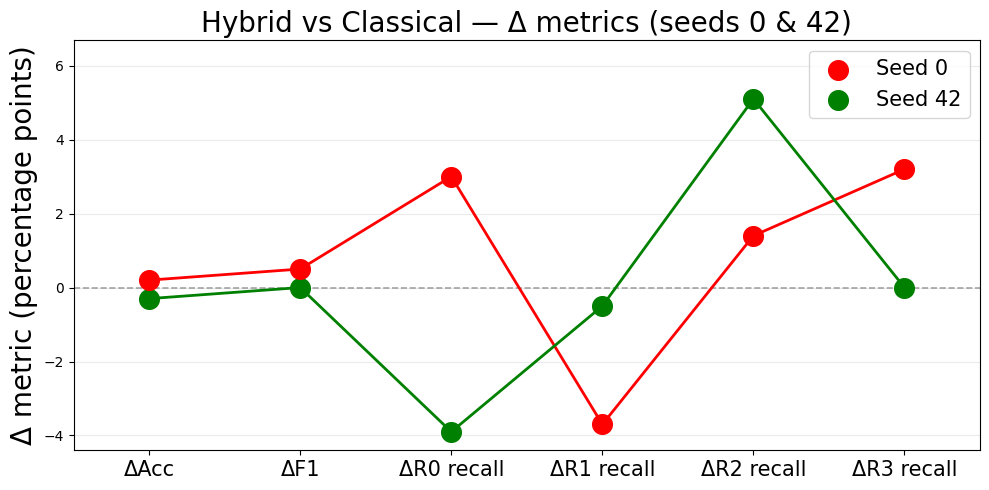

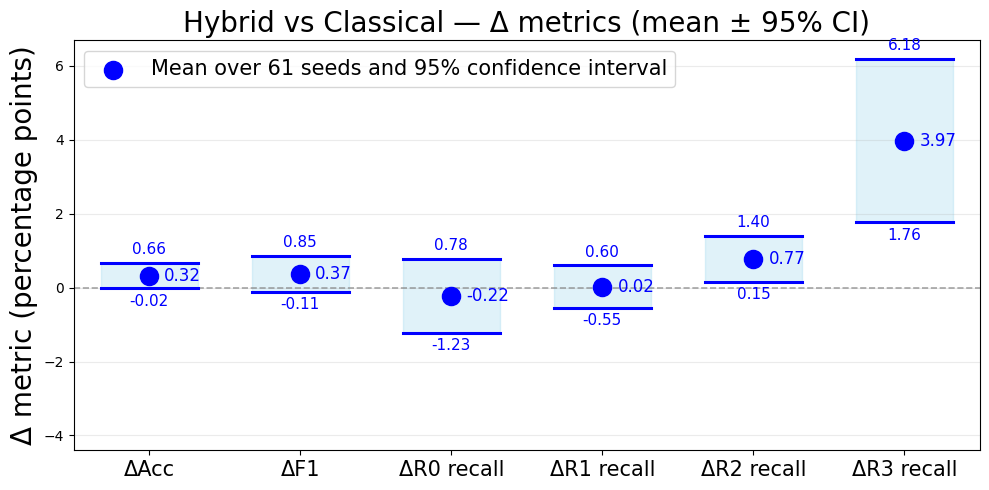

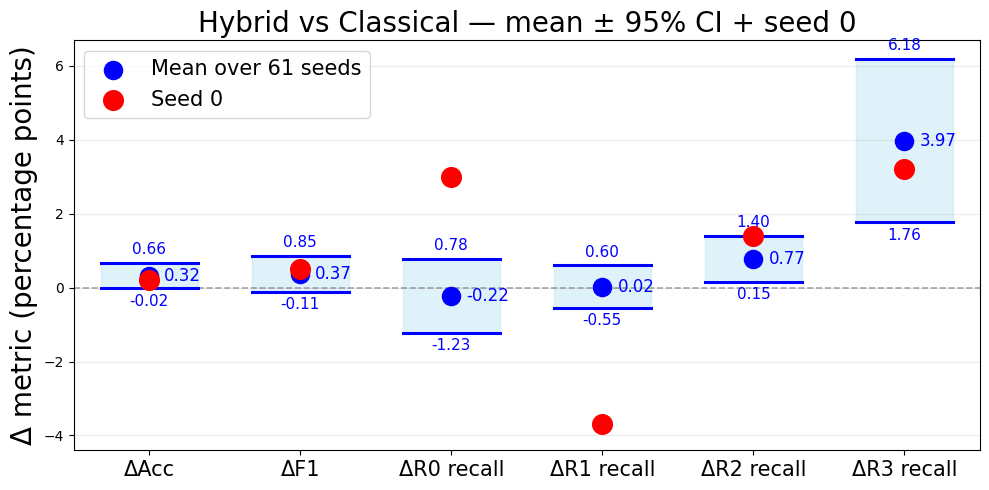

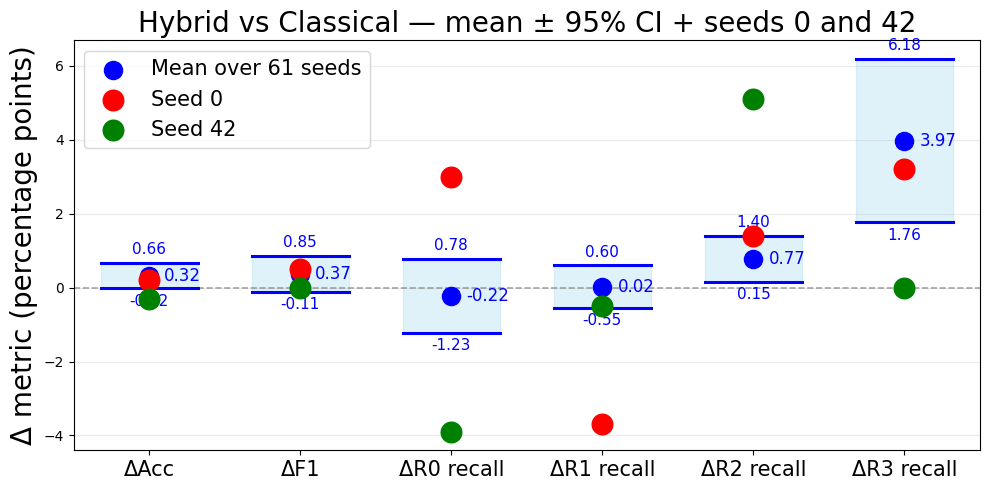

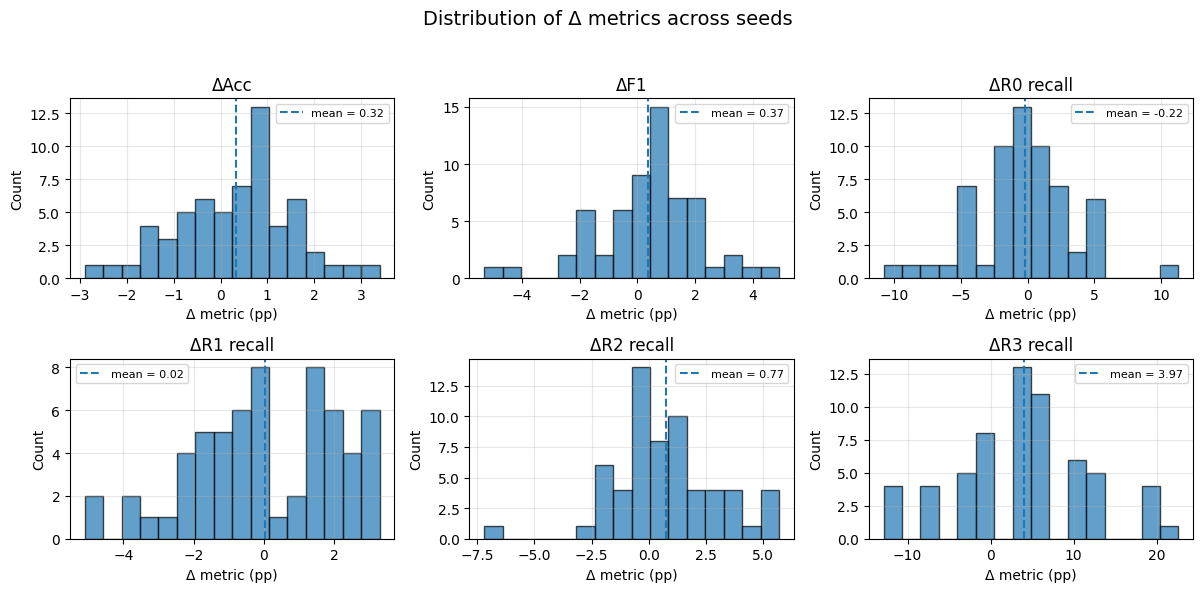

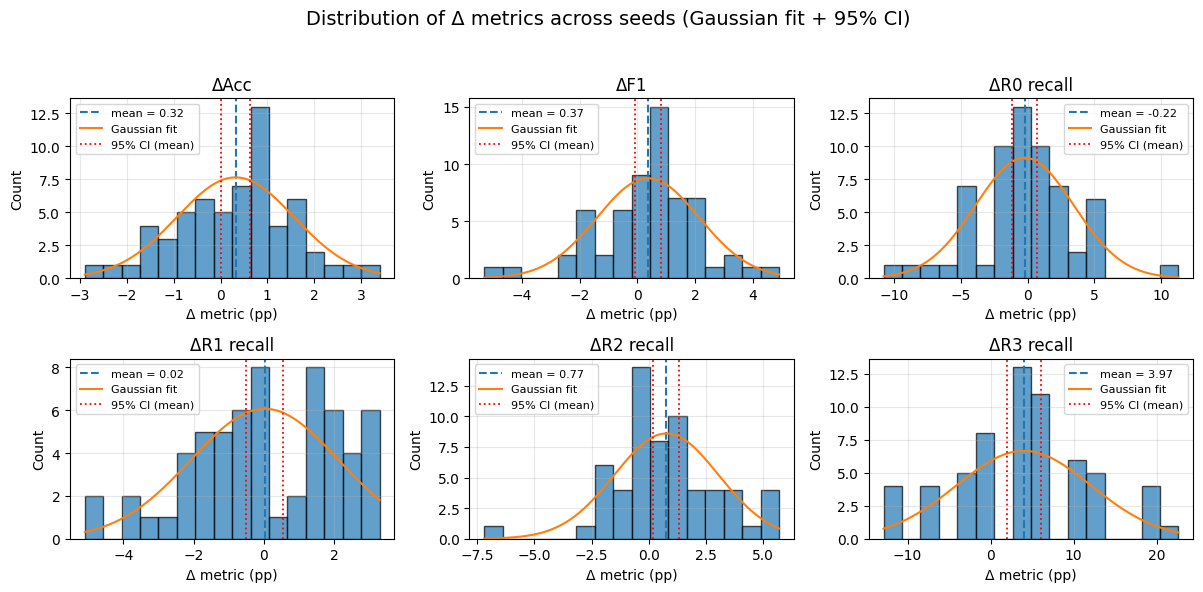

In [5]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ===============================================================
# 1) Raw log text (paste from your run)
# ===============================================================
log_text = """
🔁 IMPROVED Delta Result | seed=0 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=2.99 | Delta Acc +0.2% | Delta F1-macro +0.005 | Delta R0 recall +0.030 | Delta R1 recall -0.037 | Delta R2 recall +0.014 | Delta R3 recall +0.032

🔁 IMPROVED Delta Result | seed=42 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=2.99 | Delta Acc -0.3% | Delta F1-macro -0.000 | Delta R0 recall -0.039 | Delta R1 recall -0.005 | Delta R2 recall +0.051 | Delta R3 recall +0.000
🔁 IMPROVED Delta Result | seed=111 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc +1.0% | Delta F1-macro +0.009 | Delta R0 recall +0.054 | Delta R1 recall -0.028 | Delta R2 recall +0.000 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=234 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=2.99 | Delta Acc -1.0% | Delta F1-macro +0.005 | Delta R0 recall -0.020 | Delta R1 recall +0.009 | Delta R2 recall -0.072 | Delta R3 recall +0.194
🔁 IMPROVED Delta Result | seed=345 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.01 | Delta Acc -0.8% | Delta F1-macro +0.001 | Delta R0 recall -0.010 | Delta R1 recall -0.023 | Delta R2 recall +0.000 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=456 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc +0.7% | Delta F1-macro +0.012 | Delta R0 recall +0.020 | Delta R1 recall -0.019 | Delta R2 recall +0.014 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=567 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=2.98 | Delta Acc -1.5% | Delta F1-macro -0.041 | Delta R0 recall -0.039 | Delta R1 recall +0.014 | Delta R2 recall +0.000 | Delta R3 recall -0.129
🔁 IMPROVED Delta Result | seed=678 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.01 | Delta Acc +1.5% | Delta F1-macro +0.014 | Delta R0 recall -0.010 | Delta R1 recall +0.019 | Delta R2 recall +0.036 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=789 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.04 | Delta Acc -0.5% | Delta F1-macro -0.005 | Delta R0 recall -0.020 | Delta R1 recall -0.009 | Delta R2 recall +0.014 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=890 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.04 | Delta Acc +0.7% | Delta F1-macro +0.032 | Delta R0 recall -0.044 | Delta R1 recall +0.033 | Delta R2 recall +0.000 | Delta R3 recall +0.194
🔁 IMPROVED Delta Result | seed=901 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.06 | Delta Acc +0.8% | Delta F1-macro +0.005 | Delta R0 recall -0.010 | Delta R1 recall +0.014 | Delta R2 recall +0.029 | Delta R3 recall +0.000

🔁 IMPROVED Delta Result | seed=142 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.01 | Delta Acc +0.8% | Delta F1-macro +0.009 | Delta R0 recall +0.015 | Delta R1 recall +0.009 | Delta R2 recall -0.014 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=1111 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc -2.0% | Delta F1-macro -0.021 | Delta R0 recall -0.059 | Delta R1 recall +0.014 | Delta R2 recall -0.014 | Delta R3 recall -0.032
🔁 IMPROVED Delta Result | seed=1234 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.01 | Delta Acc -2.5% | Delta F1-macro -0.000 | Delta R0 recall -0.078 | Delta R1 recall -0.019 | Delta R2 recall +0.007 | Delta R3 recall +0.129
🔁 IMPROVED Delta Result | seed=1345 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +1.0% | Delta F1-macro -0.018 | Delta R0 recall +0.044 | Delta R1 recall -0.014 | Delta R2 recall +0.029 | Delta R3 recall -0.129
🔁 IMPROVED Delta Result | seed=1456 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc +1.5% | Delta F1-macro +0.023 | Delta R0 recall +0.000 | Delta R1 recall +0.023 | Delta R2 recall +0.007 | Delta R3 recall +0.097
🔁 IMPROVED Delta Result | seed=1567 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=2.99 | Delta Acc +2.7% | Delta F1-macro +0.019 | Delta R0 recall +0.054 | Delta R1 recall +0.019 | Delta R2 recall +0.007 | Delta R3 recall +0.000
🔁 IMPROVED Delta Result | seed=1678 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc +0.0% | Delta F1-macro +0.031 | Delta R0 recall -0.039 | Delta R1 recall +0.000 | Delta R2 recall +0.014 | Delta R3 recall +0.194
🔁 IMPROVED Delta Result | seed=1789 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.04 | Delta Acc +1.5% | Delta F1-macro +0.010 | Delta R0 recall +0.113 | Delta R1 recall -0.051 | Delta R2 recall -0.021 | Delta R3 recall +0.000
🔁 IMPROVED Delta Result | seed=1890 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +1.4% | Delta F1-macro -0.009 | Delta R0 recall +0.034 | Delta R1 recall -0.014 | Delta R2 recall +0.036 | Delta R3 recall -0.032
🔁 IMPROVED Delta Result | seed=1901 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc +0.3% | Delta F1-macro +0.016 | Delta R0 recall +0.000 | Delta R1 recall -0.019 | Delta R2 recall +0.014 | Delta R3 recall +0.129

🔁 IMPROVED Delta Result | seed=242 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc -1.4% | Delta F1-macro -0.053 | Delta R0 recall -0.005 | Delta R1 recall -0.014 | Delta R2 recall +0.000 | Delta R3 recall -0.129
🔁 IMPROVED Delta Result | seed=2111 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.01 | Delta Acc +1.9% | Delta F1-macro +0.009 | Delta R0 recall +0.054 | Delta R1 recall +0.005 | Delta R2 recall -0.007 | Delta R3 recall +0.000
🔁 IMPROVED Delta Result | seed=2234 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc +1.0% | Delta F1-macro +0.016 | Delta R0 recall +0.020 | Delta R1 recall -0.023 | Delta R2 recall +0.036 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=2345 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc +1.7% | Delta F1-macro +0.026 | Delta R0 recall +0.015 | Delta R1 recall +0.023 | Delta R2 recall -0.007 | Delta R3 recall +0.097
🔁 IMPROVED Delta Result | seed=2456 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +1.2% | Delta F1-macro +0.017 | Delta R0 recall +0.005 | Delta R1 recall +0.000 | Delta R2 recall +0.014 | Delta R3 recall +0.129
🔁 IMPROVED Delta Result | seed=2567 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.04 | Delta Acc +1.7% | Delta F1-macro +0.018 | Delta R0 recall +0.005 | Delta R1 recall +0.033 | Delta R2 recall +0.007 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=2678 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc -0.3% | Delta F1-macro -0.006 | Delta R0 recall +0.000 | Delta R1 recall -0.005 | Delta R2 recall -0.014 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=2789 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +0.3% | Delta F1-macro +0.008 | Delta R0 recall -0.030 | Delta R1 recall +0.033 | Delta R2 recall -0.014 | Delta R3 recall +0.097
🔁 IMPROVED Delta Result | seed=2890 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=2.98 | Delta Acc -0.3% | Delta F1-macro -0.002 | Delta R0 recall -0.020 | Delta R1 recall +0.014 | Delta R2 recall -0.021 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=2901 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc -0.3% | Delta F1-macro -0.005 | Delta R0 recall -0.039 | Delta R1 recall +0.019 | Delta R2 recall +0.000 | Delta R3 recall +0.065

🔁 IMPROVED Delta Result | seed=342 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc -0.8% | Delta F1-macro -0.009 | Delta R0 recall -0.010 | Delta R1 recall -0.005 | Delta R2 recall -0.021 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=3111 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +1.0% | Delta F1-macro +0.019 | Delta R0 recall -0.020 | Delta R1 recall +0.033 | Delta R2 recall +0.000 | Delta R3 recall +0.097
🔁 IMPROVED Delta Result | seed=3234 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc +1.4% | Delta F1-macro +0.011 | Delta R0 recall +0.049 | Delta R1 recall -0.019 | Delta R2 recall +0.007 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=3345 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +0.3% | Delta F1-macro +0.007 | Delta R0 recall +0.005 | Delta R1 recall -0.005 | Delta R2 recall +0.021 | Delta R3 recall -0.032
🔁 IMPROVED Delta Result | seed=3456 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc +0.3% | Delta F1-macro +0.001 | Delta R0 recall +0.015 | Delta R1 recall -0.009 | Delta R2 recall +0.007 | Delta R3 recall +0.000
🔁 IMPROVED Delta Result | seed=3567 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc +1.0% | Delta F1-macro +0.009 | Delta R0 recall -0.015 | Delta R1 recall +0.000 | Delta R2 recall +0.057 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=3678 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc +3.4% | Delta F1-macro +0.049 | Delta R0 recall +0.044 | Delta R1 recall +0.000 | Delta R2 recall +0.036 | Delta R3 recall +0.194
🔁 IMPROVED Delta Result | seed=3789 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc -0.8% | Delta F1-macro +0.005 | Delta R0 recall -0.039 | Delta R1 recall +0.014 | Delta R2 recall -0.021 | Delta R3 recall +0.097
🔁 IMPROVED Delta Result | seed=3890 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc -2.9% | Delta F1-macro -0.025 | Delta R0 recall -0.108 | Delta R1 recall +0.019 | Delta R2 recall -0.007 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=3901 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.07 | Delta Acc -0.8% | Delta F1-macro -0.017 | Delta R0 recall -0.020 | Delta R1 recall -0.005 | Delta R2 recall +0.014 | Delta R3 recall -0.065

🔁 IMPROVED Delta Result | seed=442 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +1.0% | Delta F1-macro +0.004 | Delta R0 recall +0.025 | Delta R1 recall +0.000 | Delta R2 recall +0.000 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=4111 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc -0.7% | Delta F1-macro -0.008 | Delta R0 recall -0.050 | Delta R1 recall +0.014 | Delta R2 recall +0.014 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=4234 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +1.0% | Delta F1-macro +0.002 | Delta R0 recall +0.005 | Delta R1 recall +0.028 | Delta R2 recall +0.000 | Delta R3 recall -0.032
🔁 IMPROVED Delta Result | seed=4345 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc -1.2% | Delta F1-macro +0.006 | Delta R0 recall -0.084 | Delta R1 recall +0.014 | Delta R2 recall +0.021 | Delta R3 recall +0.129
🔁 IMPROVED Delta Result | seed=4456 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=2.97 | Delta Acc +0.0% | Delta F1-macro +0.014 | Delta R0 recall -0.005 | Delta R1 recall -0.033 | Delta R2 recall +0.028 | Delta R3 recall +0.129
🔁 IMPROVED Delta Result | seed=4567 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.04 | Delta Acc +0.2% | Delta F1-macro -0.008 | Delta R0 recall -0.015 | Delta R1 recall +0.023 | Delta R2 recall +0.007 | Delta R3 recall -0.065
🔁 IMPROVED Delta Result | seed=4678 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=2.99 | Delta Acc +0.5% | Delta F1-macro +0.002 | Delta R0 recall +0.000 | Delta R1 recall +0.000 | Delta R2 recall +0.014 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=4789 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +1.2% | Delta F1-macro +0.037 | Delta R0 recall -0.025 | Delta R1 recall +0.028 | Delta R2 recall -0.007 | Delta R3 recall +0.226
🔁 IMPROVED Delta Result | seed=4890 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.01 | Delta Acc +0.8% | Delta F1-macro +0.021 | Delta R0 recall +0.020 | Delta R1 recall -0.023 | Delta R2 recall +0.021 | Delta R3 recall +0.097
🔁 IMPROVED Delta Result | seed=4901 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc -1.4% | Delta F1-macro -0.018 | Delta R0 recall -0.020 | Delta R1 recall -0.019 | Delta R2 recall +0.014 | Delta R3 recall -0.065

🔁 IMPROVED Delta Result | seed=5442 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.04 | Delta Acc -0.5% | Delta F1-macro +0.005 | Delta R0 recall +0.015 | Delta R1 recall -0.023 | Delta R2 recall -0.021 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=5111 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.01 | Delta Acc +1.5% | Delta F1-macro +0.020 | Delta R0 recall +0.010 | Delta R1 recall +0.000 | Delta R2 recall +0.043 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=5234 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +0.2% | Delta F1-macro +0.006 | Delta R0 recall -0.015 | Delta R1 recall +0.023 | Delta R2 recall -0.021 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=5345 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +1.0% | Delta F1-macro +0.010 | Delta R0 recall +0.015 | Delta R1 recall +0.000 | Delta R2 recall +0.007 | Delta R3 recall +0.065
🔁 IMPROVED Delta Result | seed=5456 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc -1.4% | Delta F1-macro -0.020 | Delta R0 recall +0.000 | Delta R1 recall -0.051 | Delta R2 recall +0.028 | Delta R3 recall -0.032
🔁 IMPROVED Delta Result | seed=5567 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.01 | Delta Acc +0.5% | Delta F1-macro -0.006 | Delta R0 recall -0.005 | Delta R1 recall +0.019 | Delta R2 recall -0.007 | Delta R3 recall +0.032
🔁 IMPROVED Delta Result | seed=5678 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.00 | Delta Acc +0.3% | Delta F1-macro -0.024 | Delta R0 recall +0.035 | Delta R1 recall -0.037 | Delta R2 recall +0.050 | Delta R3 recall -0.129
🔁 IMPROVED Delta Result | seed=5789 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.03 | Delta Acc -1.0% | Delta F1-macro -0.015 | Delta R0 recall -0.005 | Delta R1 recall -0.005 | Delta R2 recall -0.028 | Delta R3 recall +0.000
🔁 IMPROVED Delta Result | seed=5890 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=3.02 | Delta Acc +2.0% | Delta F1-macro +0.020 | Delta R0 recall +0.030 | Delta R1 recall +0.014 | Delta R2 recall +0.021 | Delta R3 recall +0.000
🔁 IMPROVED Delta Result | seed=5901 | scale=0.7 | q_layers=3 | lr_hyb=5e-04 | noise=0.01 | out_scale_mean=2.99 | Delta Acc +2.5% | Delta F1-macro +0.003 | Delta R0 recall +0.030 | Delta R1 recall +0.019 | Delta R2 recall +0.050 | Delta R3 recall -0.065
"""

# ===============================================================
# 2) Parse the text into a DataFrame
# ===============================================================
pattern = re.compile(
    r"seed=(?P<seed>\d+).*?"
    r"Delta Acc (?P<acc_sign>[+-])(?P<acc_val>[\d\.]+)% .*?"
    r"Delta F1-macro (?P<f1_sign>[+-])(?P<f1_val>[\d\.\-]+) .*?"
    r"Delta R0 recall (?P<R0_sign>[+-])(?P<R0_val>[\d\.\-]+) .*?"
    r"Delta R1 recall (?P<R1_sign>[+-])(?P<R1_val>[\d\.\-]+) .*?"
    r"Delta R2 recall (?P<R2_sign>[+-])(?P<R2_val>[\d\.\-]+) .*?"
    r"Delta R3 recall (?P<R3_sign>[+-])(?P<R3_val>[\d\.\-]+)"
)

rows = []
for m in pattern.finditer(log_text):
    def signed(sign, val):
        v = float(val)
        return v if sign == "+" else -v

    # recall deltas are in absolute terms (0–1), convert to percentage points
    deltaR0 = signed(m.group("R0_sign"), m.group("R0_val"))
    deltaR1 = signed(m.group("R1_sign"), m.group("R1_val"))
    deltaR2 = signed(m.group("R2_sign"), m.group("R2_val"))
    deltaR3 = signed(m.group("R3_sign"), m.group("R3_val"))

    rows.append({
        "seed":        int(m.group("seed")),
        "DeltaAcc_pp": signed(m.group("acc_sign"), m.group("acc_val")),          # accuracy in percentage points
        "DeltaF1":     signed(m.group("f1_sign"),  m.group("f1_val")),           # absolute F1 delta
        "DeltaF1_pp":  signed(m.group("f1_sign"),  m.group("f1_val")) * 100.0,   # F1 in percentage points
        "DeltaR0_pp":  deltaR0 * 100.0,
        "DeltaR1_pp":  deltaR1 * 100.0,
        "DeltaR2_pp":  deltaR2 * 100.0,
        "DeltaR3_pp":  deltaR3 * 100.0,
    })

df = pd.DataFrame(rows).sort_values("seed").reset_index(drop=True)
display(df)

# ===============================================================
# 3) Compute mean and 95% CI for all 6 metrics
# ===============================================================
n = len(df)
t_crit = 2.131  # approx t_{0.975, df=15} for n=16

metric_cols = [
    "DeltaAcc_pp",
    "DeltaF1_pp",
    "DeltaR0_pp",
    "DeltaR1_pp",
    "DeltaR2_pp",
    "DeltaR3_pp",
]
labels = ["ΔAcc", "ΔF1", "ΔR0 recall", "ΔR1 recall", "ΔR2 recall", "ΔR3 recall"]

vals_mean = []
ci_low    = []
ci_high   = []

for col in metric_cols:
    vals = df[col].values
    mean = vals.mean()
    std  = vals.std(ddof=1)
    ci   = t_crit * std / np.sqrt(n)

    vals_mean.append(mean)
    ci_low.append(mean - ci)
    ci_high.append(mean + ci)

    print(f"{col}: mean = {mean:.2f} pp, 95% CI = [{mean - ci:.2f}, {mean + ci:.2f}] pp")

# Convenience aliases for Acc & F1 (if you still want to print them separately)
mean_acc, acc_low, acc_high = vals_mean[0], ci_low[0], ci_high[0]
mean_f1_pp, f1_low, f1_high = vals_mean[1], ci_low[1], ci_high[1]

print()
print(f"ΔAcc mean = {mean_acc:.2f} pp, 95% CI = [{acc_low:.2f}, {acc_high:.2f}] pp")
print(f"ΔF1 mean  = {mean_f1_pp:.2f} pp, 95% CI = [{f1_low:.2f}, {f1_high:.2f}] pp")

# ===============================================================
# 4) Plot per-seed bars + mean + CI band (Acc + F1)
# ===============================================================
seeds = df["seed"].values
x = np.arange(n)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# ---------- Δ Accuracy per seed ----------
ax = axes[0]
ax.bar(x, df["DeltaAcc_pp"])
ax.axhline(0.0, linestyle="--", linewidth=1)
# CI band
ax.axhspan(acc_low, acc_high, alpha=0.15)
# mean line
ax.axhline(mean_acc, linestyle="-", linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(seeds, rotation=45)
ax.set_xlabel("Seed")
ax.set_ylabel("Δ Accuracy (percentage points)")
ax.set_title("ΔAcc per seed (scale=0.7, L=3)")
# annotation with mean & CI
ax.text(
    0.02, 0.98,
    f"mean = {mean_acc:.2f} pp\n95% CI = [{acc_low:.2f}, {acc_high:.2f}]",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=9,
    bbox=dict(boxstyle="round", alpha=0.15)
)

# ---------- Δ F1 per seed ----------
ax = axes[1]
ax.bar(x, df["DeltaF1_pp"])
ax.axhline(0.0, linestyle="--", linewidth=1)
# CI band
ax.axhspan(f1_low, f1_high, alpha=0.15)
# mean line
ax.axhline(mean_f1_pp, linestyle="-", linewidth=1)
ax.set_xticks(x)
ax.set_xticklabels(seeds, rotation=45)
ax.set_xlabel("Seed")
ax.set_ylabel("Δ F1-macro (percentage points)")
ax.set_title("ΔF1-macro per seed (scale=0.7, L=3)")
ax.text(
    0.02, 0.98,
    f"mean = {mean_f1_pp:.2f} pp\n95% CI = [{f1_low:.2f}, {f1_high:.2f}]",
    transform=ax.transAxes,
    ha="left", va="top",
    fontsize=9,
    bbox=dict(boxstyle="round", alpha=0.15)
)

plt.tight_layout()
plt.show()

# ===============================================================
# 5a) Plot 1 — seeds 0 (red), sized for crossfade
# ===============================================================

SHOWCASE_SEED = 0
SEED2 = 42

# Extract showcase rows
row_show = df[df["seed"] == SHOWCASE_SEED].iloc[0]
row2     = df[df["seed"] == SEED2].iloc[0]

vals_showcase = [
    row_show["DeltaAcc_pp"],
    row_show["DeltaF1_pp"],
    row_show["DeltaR0_pp"],
    row_show["DeltaR1_pp"],
    row_show["DeltaR2_pp"],
    row_show["DeltaR3_pp"],
]

vals_seed2 = [
    row2["DeltaAcc_pp"],
    row2["DeltaF1_pp"],
    row2["DeltaR0_pp"],
    row2["DeltaR1_pp"],
    row2["DeltaR2_pp"],
    row2["DeltaR3_pp"],
]

x_pos = np.arange(len(labels))

# ---------- compute common y-limits ----------
all_vals_for_ylim = (
    vals_showcase + vals_seed2 + vals_mean + ci_low + ci_high
)
y_min = min(all_vals_for_ylim) - 0.5
y_max = max(all_vals_for_ylim) + 0.5

# ---------- PLOT ----------
plt.figure(figsize=(10, 5))
plt.axhline(0.0, linestyle="--", linewidth=1.2, color="gray", alpha=0.7)

# seed 0 (red)
plt.scatter(
    x_pos,
    vals_showcase,
    color="red",
    s=200,
    label=f"Seed {SHOWCASE_SEED}",
    zorder=5
)
# connect the dots with a line
plt.plot(
    x_pos,
    vals_showcase,
    color="red",
    linewidth=2,
    zorder=4  # slightly below the dots so the markers stay on top
)

# axis layout
plt.xticks(x_pos, labels, fontsize=15)
plt.xlim(-0.5, len(labels) - 0.5)
plt.ylabel("Δ metric (percentage points)", fontsize=20)
plt.title("Hybrid vs Classical — Δ metrics (seed 0)", fontsize=20)
plt.grid(axis="y", alpha=0.25)
plt.legend(fontsize=15)

plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

# ===============================================================
# 5b) Plot 1 — seeds 0 (red) + 42 (green), sized for crossfade
# ===============================================================

SHOWCASE_SEED = 0
SEED2 = 42

# Extract showcase rows
row_show = df[df["seed"] == SHOWCASE_SEED].iloc[0]
row2     = df[df["seed"] == SEED2].iloc[0]

vals_showcase = [
    row_show["DeltaAcc_pp"],
    row_show["DeltaF1_pp"],
    row_show["DeltaR0_pp"],
    row_show["DeltaR1_pp"],
    row_show["DeltaR2_pp"],
    row_show["DeltaR3_pp"],
]

vals_seed2 = [
    row2["DeltaAcc_pp"],
    row2["DeltaF1_pp"],
    row2["DeltaR0_pp"],
    row2["DeltaR1_pp"],
    row2["DeltaR2_pp"],
    row2["DeltaR3_pp"],
]

x_pos = np.arange(len(labels))

# ---------- compute common y-limits ----------
all_vals_for_ylim = (
    vals_showcase + vals_seed2 + vals_mean + ci_low + ci_high
)
y_min = min(all_vals_for_ylim) - 0.5
y_max = max(all_vals_for_ylim) + 0.5

# ---------- PLOT ----------
plt.figure(figsize=(10, 5))
plt.axhline(0.0, linestyle="--", linewidth=1.2, color="gray", alpha=0.7)

# seed 0 (red)
plt.scatter(
    x_pos,
    vals_showcase,
    color="red",
    s=200,
    label=f"Seed {SHOWCASE_SEED}",
    zorder=5
)
# connect the dots with a line
plt.plot(
    x_pos,
    vals_showcase,
    color="red",
    linewidth=2,
    zorder=4  # slightly below the dots so the markers stay on top
)

# seed 42 (green)
plt.scatter(
    x_pos,
    vals_seed2,
    color="green",
    s=200,
    label=f"Seed {SEED2}",
    zorder=4
)
# connect the dots with a line
plt.plot(
    x_pos,
    vals_seed2,
    color="green",
    linewidth=2,
    zorder=4  # slightly below the dots so the markers stay on top
)
# axis layout
plt.xticks(x_pos, labels, fontsize=15)
plt.xlim(-0.5, len(labels) - 0.5)
plt.ylabel("Δ metric (percentage points)", fontsize=20)
plt.title("Hybrid vs Classical — Δ metrics (seeds 0 & 42)", fontsize=20)
plt.grid(axis="y", alpha=0.25)
plt.legend(fontsize=15)

plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()


# ===============================================================
# 6) Plot 2 — Mean + CI band + blue lines + red seed=0
# ===============================================================

plt.figure(figsize=(10, 5))
plt.axhline(0.0, linestyle="--", linewidth=1.2, color="gray", alpha=0.7)

# --- CI bands + blue lines + numeric labels -----------------------------
for i in range(len(labels)):

    # light-blue confidence band
    plt.fill_between(
        [x_pos[i] - 0.32, x_pos[i] + 0.32],
        ci_low[i],
        ci_high[i],
        color="skyblue",
        alpha=0.25,
        zorder=1
    )

    # top boundary line
    plt.plot(
        [x_pos[i] - 0.32, x_pos[i] + 0.32],
        [ci_high[i], ci_high[i]],
        color="blue",
        linewidth=2.2,
        zorder=2
    )

    # bottom boundary line
    plt.plot(
        [x_pos[i] - 0.32, x_pos[i] + 0.32],
        [ci_low[i], ci_low[i]],
        color="blue",
        linewidth=2.2,
        zorder=2
    )

    # === CI HIGH label ===
    plt.text(
        x_pos[i],
        ci_high[i] + 0.15,
        f"{ci_high[i]:.2f}",
        color="blue",
        fontsize=11,
        ha="center",
        va="bottom"
    )

    # === CI LOW label ===
    plt.text(
        x_pos[i],
        ci_low[i] - 0.15,
        f"{ci_low[i]:.2f}",
        color="blue",
        fontsize=11,
        ha="center",
        va="top"
    )

    # === MEAN LABEL (RIGHT SIDE) ===
    plt.text(
        x_pos[i] + 0.10,     # shift to the right
        vals_mean[i],
        f"{vals_mean[i]:.2f}",
        color="blue",
        fontsize=12,
        ha="left",
        va="center"
    )

# --- Mean values (strong blue points) -----------------------------------
plt.scatter(
    x_pos,
    vals_mean,
    color="blue",
    s=170,
    zorder=4,
    label=f"Mean over {n} seeds and 95% confidence interval"
)

# Layout
plt.xticks(x_pos, labels, fontsize=15)
plt.xlim(-0.5, len(labels) - 0.5)
plt.ylabel("Δ metric (percentage points)", fontsize=20)
plt.title("Hybrid vs Classical — Δ metrics (mean ± 95% CI)", fontsize=20)
plt.grid(axis="y", alpha=0.25)
plt.legend(fontsize=15)

plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()


# ===============================================================
# 7) Plot 3 — Mean ± 95% CI + blue mean dots + red seed 0 dots
# ===============================================================

plt.figure(figsize=(10, 5))
plt.axhline(0.0, linestyle="--", linewidth=1.2, color="gray", alpha=0.7)

for i in range(len(labels)):
    # light-blue confidence band
    plt.fill_between(
        [x_pos[i] - 0.32, x_pos[i] + 0.32],
        ci_low[i],
        ci_high[i],
        color="skyblue",
        alpha=0.25,
        zorder=1
    )

    # top boundary line
    plt.plot(
        [x_pos[i] - 0.32, x_pos[i] + 0.32],
        [ci_high[i], ci_high[i]],
        linewidth=2.2,
        color="blue",
        zorder=2
    )

    # bottom boundary line
    plt.plot(
        [x_pos[i] - 0.32, x_pos[i] + 0.32],
        [ci_low[i], ci_low[i]],
        linewidth=2.2,
        color="blue",
        zorder=2
    )

    # CI HIGH label
    plt.text(
        x_pos[i],
        ci_high[i] + 0.15,
        f"{ci_high[i]:.2f}",
        color="blue",
        fontsize=11,
        ha="center",
        va="bottom"
    )

    # CI LOW label
    plt.text(
        x_pos[i],
        ci_low[i] - 0.15,
        f"{ci_low[i]:.2f}",
        color="blue",
        fontsize=11,
        ha="center",
        va="top"
    )

    # MEAN LABEL (right side)
    plt.text(
        x_pos[i] + 0.10,
        vals_mean[i],
        f"{vals_mean[i]:.2f}",
        color="blue",
        fontsize=12,
        ha="left",
        va="center"
    )

# blue mean points
plt.scatter(
    x_pos,
    vals_mean,
    s=170,
    color="blue",
    zorder=4,
    label=f"Mean over {n} seeds"
)

# red points for seed 0
plt.scatter(
    x_pos,
    vals_showcase,
    s=200,
    color="red",
    zorder=5,
    label=f"Seed {SHOWCASE_SEED}"
)

plt.xticks(x_pos, labels, fontsize=15)
plt.xlim(-0.5, len(labels) - 0.5)
plt.ylabel("Δ metric (percentage points)", fontsize=20)
plt.title("Hybrid vs Classical — mean ± 95% CI + seed 0", fontsize=20)
plt.grid(axis="y", alpha=0.25)
plt.legend(fontsize=15)

plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()


# ===============================================================
# 8) Plot 4 — Mean ± 95% CI + blue mean dots + red (0) + green (42)
# ===============================================================

plt.figure(figsize=(10, 5))
plt.axhline(0.0, linestyle="--", linewidth=1.2, color="gray", alpha=0.7)

for i in range(len(labels)):
    # confidence band
    plt.fill_between(
        [x_pos[i] - 0.32, x_pos[i] + 0.32],
        ci_low[i],
        ci_high[i],
        color="skyblue",
        alpha=0.25,
        zorder=1
    )

    # top CI boundary
    plt.plot(
        [x_pos[i] - 0.32, x_pos[i] + 0.32],
        [ci_high[i], ci_high[i]],
        color="blue",
        linewidth=2.2,
        zorder=2
    )

    # bottom CI boundary
    plt.plot(
        [x_pos[i] - 0.32, x_pos[i] + 0.32],
        [ci_low[i], ci_low[i]],
        color="blue",
        linewidth=2.2,
        zorder=2
    )

    # CI HIGH label
    plt.text(
        x_pos[i],
        ci_high[i] + 0.15,
        f"{ci_high[i]:.2f}",
        color="blue",
        fontsize=11,
        ha="center",
        va="bottom"
    )

    # CI LOW label
    plt.text(
        x_pos[i],
        ci_low[i] - 0.15,
        f"{ci_low[i]:.2f}",
        color="blue",
        fontsize=11,
        ha="center",
        va="top"
    )

    # mean label (aligned right)
    plt.text(
        x_pos[i] + 0.10,
        vals_mean[i],
        f"{vals_mean[i]:.2f}",
        color="blue",
        fontsize=12,
        ha="left",
        va="center"
    )

# --- mean (blue) ---
plt.scatter(
    x_pos,
    vals_mean,
    s=170,
    color="blue",
    zorder=4,
    label=f"Mean over {n} seeds"
)

# --- seed 1456 (red) ---
plt.scatter(
    x_pos,
    vals_showcase,
    s=220,
    color="red",
    zorder=5,
    label=f"Seed {SHOWCASE_SEED}"
)

# --- seed 42 (green) ---
plt.scatter(
    x_pos,
    vals_seed2,
    s=220,
    color="green",
    zorder=6,
    label=f"Seed {SEED2}"
)

# layout
plt.xticks(x_pos, labels, fontsize=15)
plt.xlim(-0.5, len(labels) - 0.5)
plt.ylabel("Δ metric (percentage points)", fontsize=20)
plt.title("Hybrid vs Classical — mean ± 95% CI + seeds 0 and 42", fontsize=20)
plt.grid(axis="y", alpha=0.25)
plt.legend(fontsize=15)

plt.ylim(y_min, y_max)
plt.tight_layout()
plt.show()

# ===============================================================
# 9) Plot 5 — Histograms for all 6 metrics
# ===============================================================

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, (col, lbl) in enumerate(zip(metric_cols, labels)):
    ax = axes[i]
    data = df[col].values

    # histogram of the per-seed values
    ax.hist(
        data,
        bins=min(16, len(data)//2 if len(data) > 1 else 1),
        alpha=0.7,
        edgecolor="black"
    )

    # vertical line at mean
    ax.axvline(
        vals_mean[i],
        linestyle="--",
        linewidth=1.5,
        label=f"mean = {vals_mean[i]:.2f}"
    )

    ax.set_title(lbl)
    ax.set_xlabel("Δ metric (pp)")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle("Distribution of Δ metrics across seeds", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# ===============================================================
# 10) Plot 6 — Histograms + Gaussian fit + 95% CI
# ===============================================================

from scipy.stats import norm  # if not already imported above

fig, axes = plt.subplots(2, 3, figsize=(12, 6))
axes = axes.flatten()

for i, (col, lbl) in enumerate(zip(metric_cols, labels)):
    ax = axes[i]
    data = df[col].values

    if len(data) == 0:
        continue

    # histogram of the per-seed values
    bins = min(16, len(data)//2 if len(data) > 1 else 1)
    counts, bin_edges, _ = ax.hist(
        data,
        bins=bins,
        alpha=0.7,
        edgecolor="black"
    )

    # mean
    mu = np.mean(data)
    ax.axvline(
        mu,
        linestyle="--",
        linewidth=1.5,
        label=f"mean = {mu:.2f}"
    )

    # Gaussian fit + 95% CI, only if we have some spread
    if len(data) > 1:
        sigma = np.std(data, ddof=1)

        if sigma > 0:
            # x-grid over the histogram range
            x_min, x_max = bin_edges[0], bin_edges[-1]
            xs = np.linspace(x_min, x_max, 200)

            pdf = norm.pdf(xs, loc=mu, scale=sigma)
            bin_width = bin_edges[1] - bin_edges[0]
            pdf_scaled = pdf * len(data) * bin_width
            ax.plot(xs, pdf_scaled, linewidth=1.5, label="Gaussian fit")

            # --- 95% CI of the mean ------------------------------------
            se = sigma / np.sqrt(len(data))          # standard error
            ci_low = mu - 1.96 * se
            ci_high = mu + 1.96 * se

            ax.axvline(ci_low, color="red", linestyle=":", linewidth=1.3,
                       label="95% CI (mean)")
            ax.axvline(ci_high, color="red", linestyle=":", linewidth=1.3,
                       label="_nolegend_")

    ax.set_title(lbl)
    ax.set_xlabel("Δ metric (pp)")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)
    ax.legend(fontsize=8)

plt.suptitle("Distribution of Δ metrics across seeds (Gaussian fit + 95% CI)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




▶ Showcase config: seed=0, scale=0.7, q_layers=3
Classical MLP (seed=0) Ep001 | Train 1.392 | Val 1.374
Classical MLP (seed=0) Ep010 | Train 0.735 | Val 0.818
Classical MLP (seed=0) Ep020 | Train 0.400 | Val 0.630
Classical MLP (seed=0) Ep030 | Train 0.322 | Val 0.606
Classical MLP (seed=0) Ep040 | Train 0.284 | Val 0.571
Classical MLP (seed=0) Ep050 | Train 0.253 | Val 0.529
Classical MLP (seed=0) Ep060 | Train 0.225 | Val 0.500
Classical MLP (seed=0) Ep070 | Train 0.209 | Val 0.487
Classical MLP (seed=0) Ep080 | Train 0.197 | Val 0.481
Classical MLP (seed=0) Ep090 | Train 0.188 | Val 0.484
Classical MLP (seed=0) Ep100 | Train 0.180 | Val 0.485
Classical MLP (seed=0): early stop at 106 (best Val 0.4795)
Hybrid 8Q (seed=0, s=0.7, L=3) Ep001 | Train 1.456 | Val 1.364
Hybrid 8Q (seed=0, s=0.7, L=3) Ep010 | Train 0.570 | Val 0.714
Hybrid 8Q (seed=0, s=0.7, L=3) Ep020 | Train 0.357 | Val 0.551
Hybrid 8Q (seed=0, s=0.7, L=3) Ep030 | Train 0.295 | Val 0.517
Hybrid 8Q (seed=0, s=0.7, L=3) Ep0

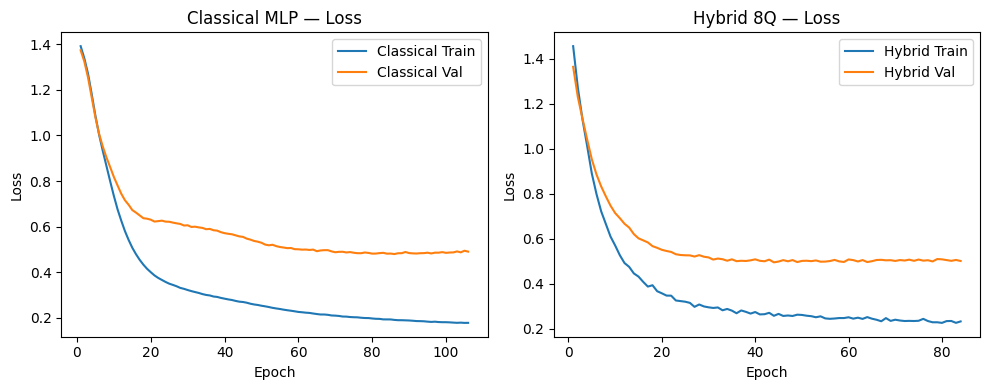

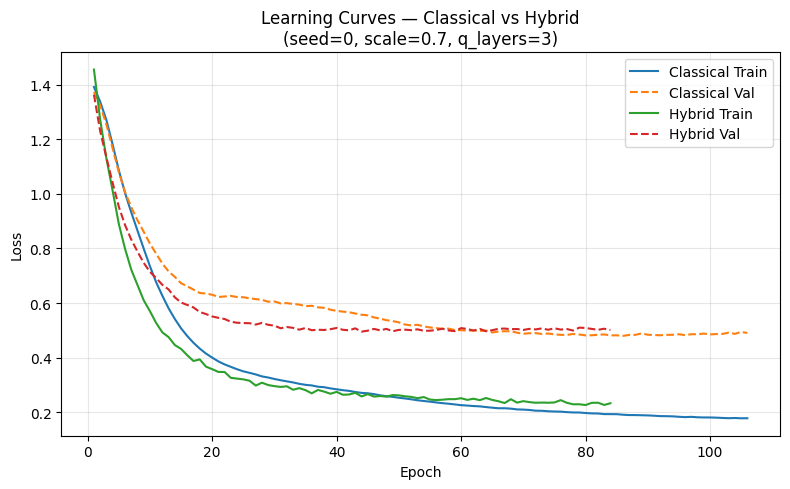

In [ ]:
# ===============================================================
# 📈 LEARNING CURVES — CLASSICAL VS HYBRID (ONE SEED / CONFIG)
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt

# --- Choose config for the "showcase" run ---
SHOWCASE_SEED   = 0
SHOWCASE_SCALE  = 0.7   # or 0.8, etc.
SHOWCASE_LAYERS = 3     # or 2, etc.

print(f"▶ Showcase config: seed={SHOWCASE_SEED}, scale={SHOWCASE_SCALE}, q_layers={SHOWCASE_LAYERS}")

# -----------------------------
# 1) Train Classical baseline
# -----------------------------
set_seed_all(SHOWCASE_SEED)
cls_model = ClassicalMLP_EncHead(input_dim=input_dim, n_qubits=8).to(device)
cls_model, (cls_train_hist, cls_val_hist) = train_with_earlystop(
    cls_model,
    name=f"Classical MLP (seed={SHOWCASE_SEED})",
    lr=5e-4,
    patience=20,
    max_epochs=200,
    verbose=True,
    log_every=10,
)

res_cls = evaluate_model(cls_model)
cm_cls = np.array(res_cls["cm"], dtype=float)

# -----------------------------
# 2) Train Hybrid model (using the same seed)
# -----------------------------
set_seed_all(SHOWCASE_SEED)
# reuse the *trained* classical encoder for a fair comparison
hyb_model = ImprovedHybrid8Q(
    input_dim=input_dim,
    n_qubits=8,
    q_layers=SHOWCASE_LAYERS,
    input_scale=SHOWCASE_SCALE,
    noise_factor=0.01,
    pretrained_encoder=cls_model.encoder,  # encoder from trained classical model
    freeze_encoder=True,
    partial_unfreeze=True,                 # allow last encoder layer to adapt slightly
).to(device)

hyb_model, (hyb_train_hist, hyb_val_hist) = train_with_earlystop(
    hyb_model,
    name=f"Hybrid 8Q (seed={SHOWCASE_SEED}, s={SHOWCASE_SCALE}, L={SHOWCASE_LAYERS})",
    lr=5e-4,
    patience=40,
    max_epochs=200,
    verbose=True,
    log_every=10,
)

res_hyb = evaluate_model(hyb_model)
cm_hyb = np.array(res_hyb["cm"], dtype=float)

# -----------------------------
# 3) Plot learning curves
# -----------------------------
epochs_cls = range(1, len(cls_train_hist) + 1)
epochs_hyb = range(1, len(hyb_train_hist) + 1)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(epochs_cls, cls_train_hist, label="Classical Train")
plt.plot(epochs_cls, cls_val_hist,   label="Classical Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Classical MLP — Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_hyb, hyb_train_hist, label="Hybrid Train")
plt.plot(epochs_hyb, hyb_val_hist,   label="Hybrid Val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Hybrid 8Q — Loss")
plt.legend()

plt.tight_layout()
plt.show()

# -----------------------------
# 4) Combined learning curves (one graph)
# -----------------------------
epochs_cls = np.arange(1, len(cls_train_hist) + 1)
epochs_hyb = np.arange(1, len(hyb_train_hist) + 1)

plt.figure(figsize=(8, 5))

# Classical
plt.plot(epochs_cls, cls_train_hist, label="Classical Train", linestyle="-")
plt.plot(epochs_cls, cls_val_hist,   label="Classical Val",   linestyle="--")

# Hybrid
plt.plot(epochs_hyb, hyb_train_hist, label="Hybrid Train", linestyle="-")
plt.plot(epochs_hyb, hyb_val_hist,   label="Hybrid Val",   linestyle="--")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(
    f"Learning Curves — Classical vs Hybrid\n"
    f"(seed={SHOWCASE_SEED}, scale={SHOWCASE_SCALE}, q_layers={SHOWCASE_LAYERS})"
)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

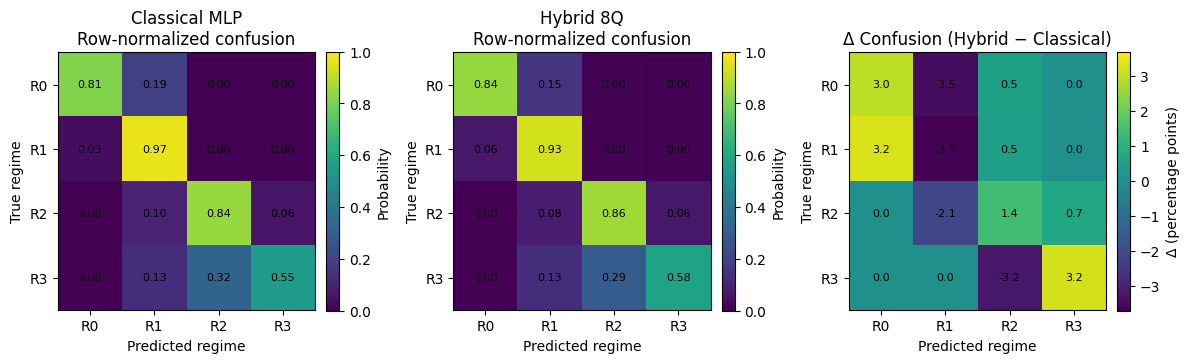

=== Classification Metrics (from confusion matrices) ===
Classical Acc:      0.8627
Hybrid Acc:         0.8644
Delta Acc:          +0.0017

Classical F1-macro: 0.8093
Hybrid F1-macro:    0.8141
Delta F1-macro:     +0.0048


In [ ]:
# ===============================================================
# 📊 4×4 CONFUSION MATRICES — CLASSICAL VS HYBRID + DELTA (HEATMAPS)
# ===============================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Make sure cm_cls and cm_hyb exist from the previous cell
assert cm_cls.shape == (N_CLASSES, N_CLASSES)
assert cm_hyb.shape == (N_CLASSES, N_CLASSES)

# Row-normalize (true-class normalization)
row_sums_cls = cm_cls.sum(axis=1, keepdims=True)
row_sums_hyb = cm_hyb.sum(axis=1, keepdims=True)

p_cls = cm_cls / row_sums_cls       # probabilities per row
p_hyb = cm_hyb / row_sums_hyb
delta_p = (p_hyb - p_cls) * 100.0   # in percentage points

regime_labels = ["R0 Calm", "R1 Sideways", "R2 Bear", "R3 Stress"]
tick_labels = ["R0", "R1", "R2", "R3"]  # shorter labels for axes

# Optional: DataFrames (not displayed, but handy for inspection)
df_cls = pd.DataFrame(
    p_cls,
    index=[f"True {r}" for r in regime_labels],
    columns=[f"Pred {r}" for r in regime_labels],
)
df_hyb = pd.DataFrame(
    p_hyb,
    index=[f"True {r}" for r in regime_labels],
    columns=[f"Pred {r}" for r in regime_labels],
)
df_delta = pd.DataFrame(
    delta_p,
    index=[f"True {r}" for r in regime_labels],
    columns=[f"Pred {r}" for r in regime_labels],
)

# ---------------------------------------------------------------
# Helper to plot one 4x4 matrix with annotations
# ---------------------------------------------------------------
def plot_matrix(ax, mat, title, vmin=None, vmax=None, fmt="{:.2f}", colorbar_label=None):
    im = ax.imshow(mat, vmin=vmin, vmax=vmax, aspect="equal")
    ax.set_xticks(np.arange(N_CLASSES))
    ax.set_yticks(np.arange(N_CLASSES))
    ax.set_xticklabels(tick_labels)
    ax.set_yticklabels(tick_labels)
    ax.set_xlabel("Predicted regime")
    ax.set_ylabel("True regime")
    ax.set_title(title)

    # Annotate each cell
    for i in range(N_CLASSES):
        for j in range(N_CLASSES):
            ax.text(
                j, i,
                fmt.format(mat[i, j]),
                ha="center",
                va="center",
                fontsize=8,
            )

    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    if colorbar_label is not None:
        cbar.set_label(colorbar_label)

# ---------------------------------------------------------------
# Plot: Classical, Hybrid, Delta side by side
# ---------------------------------------------------------------
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Classical confusion (probabilities)
plot_matrix(
    axes[0],
    p_cls,
    title="Classical MLP\nRow-normalized confusion",
    vmin=0.0,
    vmax=1.0,
    fmt="{:.2f}",
    colorbar_label="Probability",
)

# Hybrid confusion (probabilities)
plot_matrix(
    axes[1],
    p_hyb,
    title="Hybrid 8Q\nRow-normalized confusion",
    vmin=0.0,
    vmax=1.0,
    fmt="{:.2f}",
    colorbar_label="Probability",
)

# Delta confusion (percentage points, can be pos/neg)
max_abs_delta = np.max(np.abs(delta_p))
plot_matrix(
    axes[2],
    delta_p,
    title="Δ Confusion (Hybrid − Classical)",
    vmin=-max_abs_delta,
    vmax= max_abs_delta,
    fmt="{:.1f}",
    colorbar_label="Δ (percentage points)",
)

plt.tight_layout()
# Optional for video:
# plt.savefig("confusion_matrices_classical_vs_hybrid_delta.png", dpi=300, bbox_inches="tight")
plt.show()

# ===============================================================
# 📈 Compute Accuracy and F1-macro for Classical vs Hybrid
# ===============================================================

# Use the confusion matrices cm_cls and cm_hyb + existing helper
acc_cls, f1_cls, _   = cm_to_metrics(cm_cls)
acc_hyb, f1_hyb, _   = cm_to_metrics(cm_hyb)

delta_acc = acc_hyb - acc_cls
delta_f1  = f1_hyb - f1_cls

print("=== Classification Metrics (from confusion matrices) ===")
print(f"Classical Acc:      {acc_cls:.4f}")
print(f"Hybrid Acc:         {acc_hyb:.4f}")
print(f"Delta Acc:          {delta_acc:+.4f}")
print("")
print(f"Classical F1-macro: {f1_cls:.4f}")
print(f"Hybrid F1-macro:    {f1_hyb:.4f}")
print(f"Delta F1-macro:     {delta_f1:+.4f}")
print("========================================================")